# Diffusion Models for Image Generation 

Generative image models (and generative AI as a whole) have gained significant attention over the last few years. Model types you may have heard of like GANs, have shown success in creating realistic looking images. Diffusion models are a relatively new class of models and have recently demonstrated state-of-the-art performance with image generation. Diffusion models were [first conceptualized for image generation in 2015](https://arxiv.org/pdf/1503.03585.pdf) and now underpin many of the leading image generation systems. Diffusion models consist of two processes:

* The forward (noising) process: Slowly add noise to an image, destroying structure in the data distribution 
* The reverse (de-noising) process: Learn the reverse diffusion process, yielding a generative model of the data

In other words, the forward process adds random noise to an image and the reverse process learns to remove noise from an image. After training, we can use the model from the reverse process to iteratively remove noise from a random-noise starting point and generate images.

In this lab, you will:
* Load the dataset 
* Define the de-noising model (U-net with residual connections) 
* Define the [diffusion model](https://arxiv.org/pdf/2010.02502.pdf) (forward and reverse processes) 
* Train the diffusion model and visualize results 

### Setup 

In [ ]:
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

print(tf.__version__)

### Choose dataset
This lab can be ran with either the flowers dataset or mnist dataset. **NOTE**: To train the model on the flowers dataset, it requires a GPU. To train a model faster, or without a GPU, choose the mnist dataset.

In [ ]:
# dataset_choice = "flowers"
dataset_choice = "mnist"

Define global variables for each dataset. Some of these variables can be the same, regardless of which dataset you are using. 

* `CENTRAL_CROP`: Used only for the flowers dataset to define a percentage to centrally crop each source image. 
* `MIN_SIGNAL_RATE` & `MAX_SIGNAL_RATE`: These are hyperparameters of the forward diffusion process. In this notebook, we will be using a continuous diffusion schedule. These hyperparameters define the minimum and maximum "amount" of the source image to be included at any iteration of the noising process. Note: A min_signal_rate of 0 will cause a division by zero error. The optimal min and max signal rate (in terms of yielding the best image generation quality) may not be the same for different datasets. 
* `PLOT_DIFFUSION_STEPS`: This defines the number of de-noising steps to take when generating/plotting images at the end of each training epoch.
* `EMA`: Defines the smoothing applied to the exponential moving average of weights. While generating images with a trained diffusion model, it generally yields better performance to use an exponential moving average of the model weights instead of simply the weights after the last training step.  

In [ ]:
if dataset_choice == "flowers":
    IMAGE_SIZE = 64
    IMAGE_CHANNELS = 3
    WIDTHS = [64, 128, 128, 256]
    DATASET_NAME = "oxford_flowers102"
    DATASET_SPLIT = "test"
    CENTRAL_CROP = 0.8

elif dataset_choice == "mnist":
    IMAGE_SIZE = 28
    IMAGE_CHANNELS = 1
    WIDTHS = [8, 16, 32]
    NUM_EXAMPLES = 10000

else:
    raise ValueError("Please specify dataset_choice in the cell above.")

BLOCK_DEPTH = 2
EPOCHS = 50
BATCH_SIZE = 32
MIN_SIGNAL_RATE = 0.02
MAX_SIGNAL_RATE = 0.95
PLOT_DIFFUSION_STEPS = 25
EMA = 0.999
OUTPUT_DIR = "diffusion_model"
CHECKPOINT_DIR = os.path.join(OUTPUT_DIR, "checkpoints")

print(f"Using dataset: {dataset_choice}")

### Load dataset 

Define a function to load the dataset. This lab uses either the [Oxford Flower Dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102) or the [MNIST Dataset](https://www.tensorflow.org/datasets/catalog/mnist). The flowers dataset contains images of flowers commonly found in the UK, and the MNIST dataset contains grayscale images of handwritten digits. 

In [ ]:
# tf data ingest for flowers dataset
def _preprocess_flowers(data):
    image = data["image"]
    image = tf.image.central_crop(image, CENTRAL_CROP)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.image.resize(
        image, size=[IMAGE_SIZE, IMAGE_SIZE], antialias=True
    )
    return tf.clip_by_value(image, 0.0, 1.0)


def create_dataset_flowers(batch_size):
    ds = tfds.load(DATASET_NAME, split=DATASET_SPLIT)
    ds = ds.map(
        _preprocess_flowers, num_parallel_calls=tf.data.AUTOTUNE
    ).cache()
    return ds.batch(batch_size, drop_remainder=True).prefetch(tf.data.AUTOTUNE)


# tf data ingest for mnist dataset
def _preprocess_mnist(image):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.expand_dims(image, -1)
    return tf.clip_by_value(image, 0.0, 1.0)


def create_dataset_mnist(batch_size):
    (X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
    ds = tf.data.Dataset.from_tensor_slices(X_train[:NUM_EXAMPLES])
    ds = ds.map(_preprocess_mnist, num_parallel_calls=tf.data.AUTOTUNE).cache()
    return ds.batch(batch_size, drop_remainder=True)

### Forward Diffusion Process
We will have a diffusion process starting at time = 0, and ending at time = 1. This diffusion time can be discrete (as implemented in [Denoinsing Diffusion Probabalistic Models](https://arxiv.org/pdf/2006.11239.pdf)) or continuous (as implemented in [Denoising Diffusion Implicit Models](https://arxiv.org/pdf/2010.02502.pdf)). This notebook uses a continuous diffusion time, which allows us to change the number of sampling steps at generation/inference time. At each diffusion time, we will have a noise level `noise_rate` and a signal level `signal_rate`. How do we know the noise and signal level for a given diffusion time? For this, we will use a simple cosine schedule as defined in `diffusion_schedule()`. We generate the noisy image (for the forward diffusion processes) by weighting random noise by the noise rate, and the training image by the signal rate, then adding them together. In other words, the noisy image at each training step will be: `noise_rate` * `noise` + `signal_rate` * `image`, where `signal_rate` and `noise_rate` are a function of diffusion time. 

Define function `diffusion_schedule()` that returns noise and signal rates for given diffusion times. Taking a look at noise/signal rates as a function of diffusion times (visually) provides an understanding that noise/signal rates are inversely related. Note that a diffusion time of 0 leads to the training image, without any noise. A diffusion time of 1 leads to pure noise. 

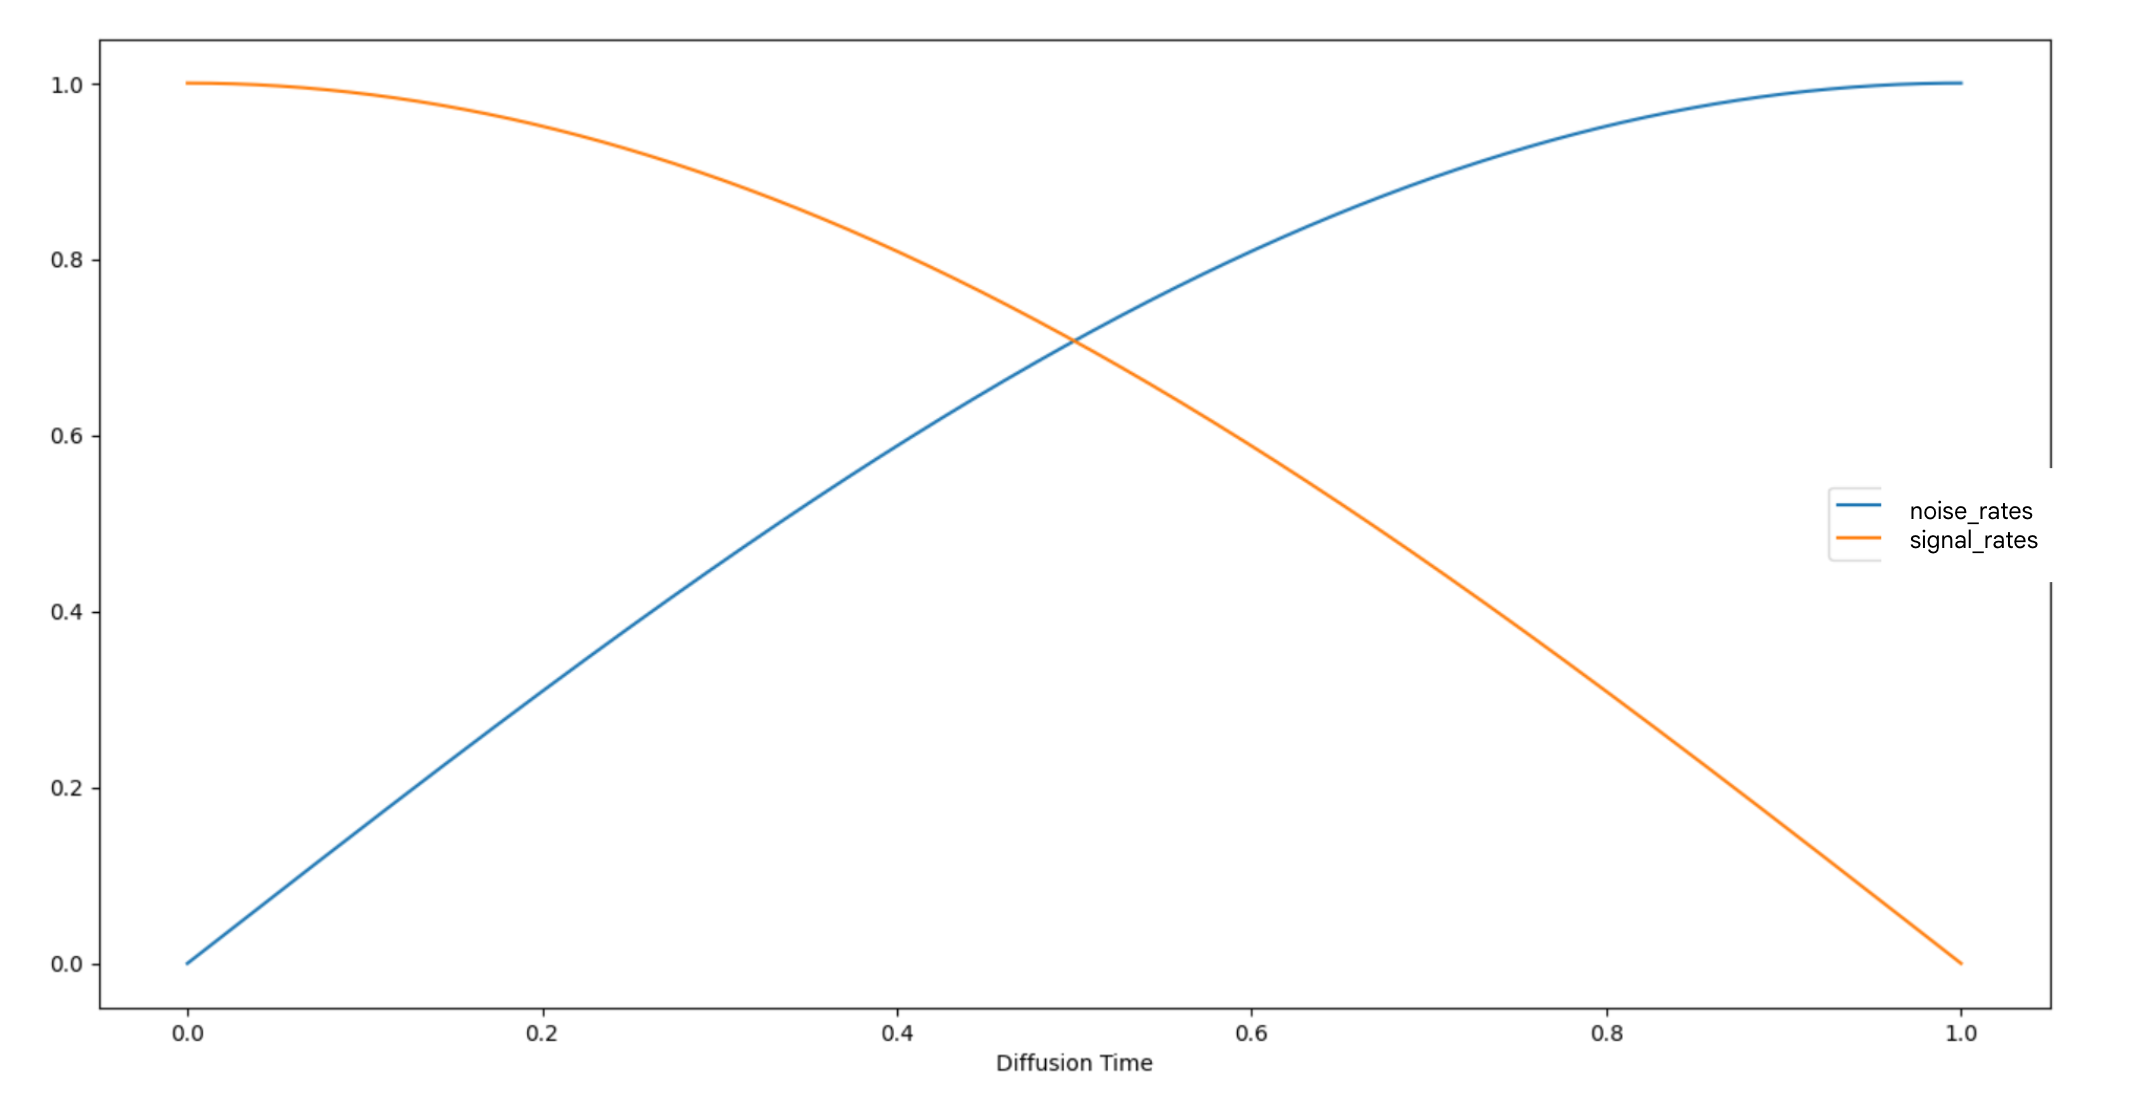

While there are many different ways to implement signal rates going from 1 to 0 (with noise rates going from 0 to 1), below is a popular and simple implementation. 

**Note**: This code needs to be implemented in a training step of a subclasses model eventually. We are only running it here directly first to visualize the forward diffusion process. 

In [ ]:
def diffusion_schedule(
    diffusion_times, max_signal_rate=0.98, min_signal_rate=0.02
):
    start_angle = tf.acos(max_signal_rate)
    end_angle = tf.acos(min_signal_rate)

    diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

    signal_rates = tf.cos(diffusion_angles)
    noise_rates = tf.sin(diffusion_angles)

    return noise_rates, signal_rates

### Visualize forward diffusion process
Apply this forward diffusion to a single image and visualize this forward diffusion of adding guassian noise at randomly sampled diffusion times between 0 and 1. 

In [ ]:
# Batch of data
if dataset_choice == "mnist":
    train_ds = create_dataset_mnist(BATCH_SIZE)
elif dataset_choice == "flowers":
    train_ds = create_dataset_flowers(BATCH_SIZE)

ds_iter = train_ds.as_numpy_iterator()
data_batch = next(ds_iter)

In [ ]:
# random noise the same size as input batch of images
noises = tf.random.normal(shape=data_batch.shape)

# random sample of diffusion times between 0 and 1
diffusion_times = tf.random.uniform(
    shape=(data_batch.shape[0], 1, 1, 1), minval=0.0, maxval=1.0
)

# compute noise and signal rates for each respective diffusion time
noise_rates, signal_rates = diffusion_schedule(diffusion_times)

# create noisy images
noisy_images = signal_rates * data_batch + noise_rates * noises

In [ ]:
# Visualize original images and noisy images
num_rows = 32
num_cols = 2
plt.figure(figsize=(8, 64))
index = 0
for row in range(num_rows - 1):
    plt.subplot(num_rows, num_cols, index + 1)
    plt.imshow(data_batch[row], cmap="gray")
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(num_rows, num_cols, index + 2)
    plt.imshow(noisy_images[row], cmap="gray")
    plt.title(
        f"t={tf.squeeze(diffusion_times[row]):.2f} | signal={tf.squeeze(signal_rates[row]):.2f} | noise={tf.squeeze(noise_rates[row]):.2f}"
    )
    plt.axis("off")
    index += 2

plt.tight_layout()
plt.show()

As you can see visually, a small diffusion time (high signal rate, low noise rate) only adds a little noise and we can still (even visually) see what the original image is. Larger diffusion times (low signal rate, high noise rate) diffuse more "aggresively" and we can visually see the structure of the initial image is essentially, completely gone. 

**NOTE** You can run the previous two cells again to visualize another forward diffusion process, since diffusion times are randomly sampled.  

### De-noinsing Model Architecture

Now we need to specify the neural network that will be used for denoising (predicting the noise added to a given image). U-Net is a popular semantic segmentation architecture, whose main idea is that it progressively downsamples and then upsamples its input image, and adds skip connections between layers having the same resolution. U-Net architectures have  shown good performance with diffusion models, likely because they are suited well for representing images in many subspaces, and inherently have the same dimensionality of input/output which is needed for a de-noising model. 

The U-Net will take in two inputs. The first input is of course the noisy image (`noise_rate` * `noise` + `signal_rate` * `image`). The de-noising model needs to be able to predict/remove noise at different levels of noise, however, so we need to pass in an input related to the noise level in addition to the noisy image. To enable our model to learn how to de-noise at different noise rates, we will pass in the square of the noise rate (noise variance). While we could simply pass in the noise rate (or the signal rate) instead, passing in the squared noise rate has nice properties (it is symetric under the sampling schedule and generally leads to better performance). We will embed noise variance in such a way that different noise variances are represented differently. We will do this with sinusoidal embeddings. This is quite similar to positional encodings used in transformers, and will allow the model to represent different noise rates uniquely, and learn patterns across noise rate variances. The output of the model is of course the predicted noise. 

Model Inputs: 
- Noisy Image: `noise_rate` * `noise` + `signal_rate` * `image` 
- Noise Variance: `noise_rate`**2

Model Output: 
- Predicted Noise 

The first layer we will define is `SinEmbedding`. The purpose of this layer is to take a noise_rate (squared) and represent it as a `embedding_dim` dimensional vector. We will use `embedding_dim=32`. The idea is that this 32 dimensional vector will be different for different noise rates, allowing the denoising model to learn how to predict/remove noise across all possible noise rates. 

In [ ]:
class SinEmbedding(tf.keras.layers.Layer):
    """
    Custom layer for embedding noise rate variance.
    """

    def __init__(
        self, embedding_dim=32, min_freq=1.0, max_freq=1000.0, **kwargs
    ):
        super().__init__(**kwargs)
        self.frequencies = tf.exp(
            tf.linspace(
                tf.math.log(min_freq), tf.math.log(max_freq), embedding_dim // 2
            )
        )

        self.angular_speeds = 2.0 * math.pi * self.frequencies

    def get_config(self):
        config = super().get_config()
        return config

    def call(self, inputs):
        inputs = tf.cast(inputs, dtype=tf.float32)
        emb = tf.concat(
            [
                tf.sin(self.angular_speeds * inputs),
                tf.cos(self.angular_speeds * inputs),
            ],
            axis=3,
        )
        return emb

This is similar to how positional encodings for transformers are created. 

We can visualize this with a heatmap (i.e. looking at how the 32 dimensional vectors change as the noise rate changes from zero to one).

In [ ]:
# noise rates ranging from zero to one
test_noise_rates = tf.reshape(tf.linspace(0.0, 1.0, 100), (100, 1, 1, 1))

# send noise rates through SinEmbedding layer
encoded_noise_variances = SinEmbedding()(test_noise_rates**2)
plt.imshow(tf.transpose(tf.squeeze(encoded_noise_variances)))
plt.xlabel("Noise Rate")
plt.xticks([0, 49, 99], ["0.0", "0.5", "1.0"])

Next define the building blocks of the U-Net architecture. This will be composed of:
* `ResidualBlock()`: Convolutional layers with an additive skip connection
* `DownBlock()`: (downstack) Residual blocks followed by average pooling 
* `UpBlock()`: (upstack) Bilinear upsampling followed by residual blocks, concatenating same dimensionalities from downstack. Note that you could also use transpose convolutional layers (instead of bilinear upsampling) and that may lead to better performance.

Then define `get_network`: A function that will use the building blocks to compose the de-noising network. 

In [ ]:
def ResidualBlock(width):
    """
    Batch norm followed by two conv layers to specified width.
    Input also skips these layers and is added to output.
    """

    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = tf.keras.layers.Conv2D(width, kernel_size=1)(x)
        x = tf.keras.layers.BatchNormalization(center=False, scale=False)(x)
        x = tf.keras.layers.Conv2D(
            width,
            kernel_size=3,
            padding="same",
            activation=tf.keras.activations.swish,
        )(x)
        x = tf.keras.layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = tf.keras.layers.Add()([x, residual])
        return x

    return apply


# Downsampling
def DownBlock(width, block_depth):
    """
    Component of down stack of residual U-Net. Stacks block_depth ResidualBlocks to specified
    width, followed by Average Pooling for dimensionality reduction i.e. downsampling.
    """

    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = tf.keras.layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply


# Upsampling
def UpBlock(width, block_depth):
    """
    Component of up stack of residual U-Net. Applies bilinear upsampling and
    stacks block_depth ResidualBlocks to specified width. Concats skip connections
    from same resolution as downstack.
    """

    def apply(x):
        x, skips = x
        x = tf.keras.layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = tf.keras.layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply


def get_network(image_size, image_channels, widths, block_depth):
    noisy_images = tf.keras.Input(
        shape=(image_size, image_size, image_channels)
    )
    noise_variances = tf.keras.Input(shape=(1, 1, 1))

    e = SinEmbedding()(noise_variances)
    e = tf.keras.layers.UpSampling2D(size=image_size, interpolation="nearest")(
        e
    )

    x = tf.keras.layers.Conv2D(widths[0], kernel_size=1)(noisy_images)
    x = tf.keras.layers.Concatenate()([x, e])

    skips = []
    for width in widths[:-1]:
        x = DownBlock(width, block_depth)([x, skips])

    for _ in range(block_depth):
        x = ResidualBlock(widths[-1])(x)

    for width in reversed(widths[:-1]):
        x = UpBlock(width, block_depth)([x, skips])

    x = tf.keras.layers.Conv2D(
        image_channels, kernel_size=1, kernel_initializer="zeros"
    )(x)

    return tf.keras.Model(
        [noisy_images, noise_variances], x, name="residual_unet"
    )

### Diffusion Model

Now that we understand the concepts and have a function to build the de-noising model, we can put everything together into one Keras Model. This class will need the following methods:

`denormalize()`: A method to denormalize pixels back to 0-1 using the keras normalization layer

`diffusion_schedule()`: A method to return noise and signal rates, given a tensor of diffusion times. This is what we implemented and ran directly above in the notebook. 

`denoise()`: A method to take in a noisy image and a noise rate, send them through the de-noising model, then remove the predicted noise from the input.

`reverse_diffusion()`: Iteratively denoise for a specified number of diffusion steps. At each step, it takes the previous estimate of the noisy image and separates it into image and noise using the trained network. Then it recombines these components using the signal and noise rate of the next step. This process occurs while iterating over diffusion times in reverse (i.e. 1 to 0)

`train_step()`: A single training step in our diffusion model does the following:
* Normalize the images and samples random Gaussian noise 
* Samples noise/signal rates from sampled diffusion times 
* Mixes the images with the noise according to noise/signal rates
* Sends the noisy images through the de-noising network (`denoise()`)
* Computes loss between predicted noise and noise 
* Updates model parameters 

`plot_images()`: A method to generate and display images with the model. While this method is not neccesary, we can use it as a callback to plot images after each epoch of training. 

Another thing to note is `self.ema_network`. While the de-noising model is `self.network`, we will also update `self.ema_network` at each training step with an exponential moving average of the weights of `self.network`. `self.ema_network` is not used while training and is only used when generating images.


In [ ]:
class DiffusionModel(tf.keras.Model):
    def __init__(
        self,
        image_size,
        image_channels,
        widths,
        block_depth,
        batch_size,
        min_signal_rate,
        max_signal_rate,
        ema,
        plot_diffusion_steps,
    ):
        super().__init__()
        self.image_size = image_size
        self.image_channels = image_channels
        self.batch_size = batch_size
        self.min_signal_rate = min_signal_rate
        self.max_signal_rate = max_signal_rate
        self.plot_diffusion_steps = plot_diffusion_steps
        self.ema = ema

        self.normalizer = tf.keras.layers.Normalization()
        self.network = get_network(
            image_size, image_channels, widths, block_depth
        )
        self.ema_network = tf.keras.models.clone_model(self.network)

    def denormalize(self, images):
        # convert the pixel values back to 0-1 range
        images = self.normalizer.mean + images * self.normalizer.variance**0.5
        return tf.clip_by_value(images, 0.0, 1.0)

    def diffusion_schedule(self, diffusion_times):
        # diffusion times -> angles
        start_angle = tf.acos(self.max_signal_rate)
        end_angle = tf.acos(self.min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (
            end_angle - start_angle
        )

        # angles -> signal and noise rates
        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates

    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        if training:
            network = self.network

        # Use EMA network for generation
        else:
            network = self.ema_network

        # predict noise component and calculate the image component using it
        pred_noises = network([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates

        return pred_noises, pred_images

    def reverse_diffusion(self, initial_noise, diffusion_steps):
        # reverse diffusion = sampling
        num_images = initial_noise.shape[0]
        step_size = 1.0 / diffusion_steps

        # at the first sampling step, noisy_image is pure noise
        # signal rate is assumed to be min_signal_rate
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images

            # separate the current noisy image to its components
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            # network used in eval mode

            # remix the predicted components using the next signal and noise rates
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            # this new noisy image will be used in the next step

        return pred_images

    def generate(self, num_images, diffusion_steps):
        # noise -> images -> denormalized images
        initial_noise = tf.random.normal(
            shape=(
                num_images,
                self.image_size,
                self.image_size,
                self.image_channels,
            )
        )
        generated_images = self.reverse_diffusion(
            initial_noise, diffusion_steps
        )
        generated_images = self.denormalize(generated_images)
        return generated_images

    def train_step(self, images):
        images = self.normalizer(images, training=True)
        noises = tf.random.normal(
            shape=(
                self.batch_size,
                self.image_size,
                self.image_size,
                self.image_channels,
            )
        )

        diffusion_times = tf.random.uniform(
            shape=(self.batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises

        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )

            noise_loss = self.loss(noises, pred_noises)  # used for training

        gradients = tape.gradient(noise_loss, self.network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.network.trainable_weights)
        )

        # track the exponential moving averages of weights
        for weight, ema_weight in zip(
            self.network.weights, self.ema_network.weights
        ):
            ema_weight.assign(self.ema * ema_weight + (1 - self.ema) * weight)

        return {"noise_loss": noise_loss}

    def plot_images(self, epoch=None, logs=None, num_rows=3, num_cols=6):
        # plot random generated images for visual evaluation of generation quality
        generated_images = self.generate(
            num_images=num_rows * num_cols,
            diffusion_steps=self.plot_diffusion_steps,
        )

        # plot in grayscale for single channel images
        cmap = None
        if self.image_channels == 1:
            cmap = "gray"

        plt.figure(figsize=(num_cols * 2.0, num_rows * 2.0))
        for row in range(num_rows):
            for col in range(num_cols):
                index = row * num_cols + col
                plt.subplot(num_rows, num_cols, index + 1)
                plt.imshow(generated_images[index], cmap=cmap)
                plt.axis("off")
        plt.tight_layout()
        plt.show()
        plt.close()

### Train the model 
Before training the model, you need to compile it and specify an optimizer and loss function. We will simply use Adam as an optimizer and mean squared error to compute the loss between the actual noise added to an image and the predicted noise. 

The model has callbacks that will generate and display images after each epoch of model training, and save checkpoints of the best model (lowest loss).  

In [ ]:
model = DiffusionModel(
    image_size=IMAGE_SIZE,
    image_channels=IMAGE_CHANNELS,
    widths=WIDTHS,
    block_depth=BLOCK_DEPTH,
    batch_size=BATCH_SIZE,
    min_signal_rate=MIN_SIGNAL_RATE,
    max_signal_rate=MAX_SIGNAL_RATE,
    plot_diffusion_steps=PLOT_DIFFUSION_STEPS,
    ema=EMA,
)

model.compile(optimizer="adam", loss=tf.keras.losses.MeanSquaredError())

# compute mean/variance of dataset for normalization layer
model.normalizer.adapt(train_ds)

model.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.LambdaCallback(on_epoch_end=model.plot_images),
        tf.keras.callbacks.ModelCheckpoint(
            CHECKPOINT_DIR,
            monitor="noise_loss",
            mode="min",
            save_best_only=True,
            save_weights_only=True,
        ),
    ],
)

Load the model in from the checkpoint file and use it to generate an image.

In [ ]:
model.load_weights(CHECKPOINT_DIR)
model.plot_images()

Congrats! You've succesfully trained a diffusion model to generate images. 